Regression Problem on Housing Price Prediction

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pylab
import seaborn as sn

from scipy.stats import skew
from scipy.stats.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Starting with data preprocessing


Int64Index([523, 691, 1182, 1298], dtype='int64')


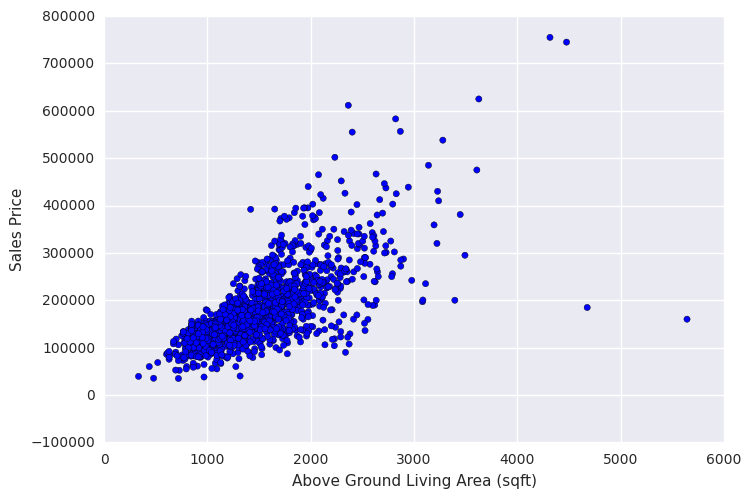

In [6]:
from sklearn.metrics import mean_squared_error
def remse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# This plot shows us there are some outliers for sqft > 4000
_ = plt.scatter(train['GrLivArea'], train['SalePrice'])
_ = plt.xlabel('Above Ground Living Area (sqft)')
_ = plt.ylabel('Sales Price')

# train.drop(train[train['GrLivArea'] > 4000].index, inplace=True) # Remove these outliers
temp = train[train['GrLivArea'] > 4000].index
print temp

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)

# I have no idea how to do it better. Probably, it is better to do nothing
x = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
y = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]
# plt.scatter(x, y)
t = (x <= 25000) & (y <= 150)
p = np.polyfit(x[t], y[t], 1)
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

all_data.loc[all_data.Alley.isnull(), 'Alley'] = 'NoAlley'
all_data.loc[all_data.MasVnrType.isnull(), 'MasVnrType'] = 'None' # no good
all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0
all_data.loc[all_data.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'
all_data.loc[all_data.BsmtCond.isnull(), 'BsmtCond'] = 'NoBsmt'
all_data.loc[all_data.BsmtExposure.isnull(), 'BsmtExposure'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType1.isnull(), 'BsmtFinType1'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType2.isnull(), 'BsmtFinType2'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
all_data.loc[all_data.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0
all_data.loc[all_data.FireplaceQu.isnull(), 'FireplaceQu'] = 'NoFireplace'
all_data.loc[all_data.GarageType.isnull(), 'GarageType'] = 'NoGarage'
all_data.loc[all_data.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'
all_data.loc[all_data.GarageQual.isnull(), 'GarageQual'] = 'NoGarage'
all_data.loc[all_data.GarageCond.isnull(), 'GarageCond'] = 'NoGarage'
all_data.loc[all_data.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
all_data.loc[all_data.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0
all_data.loc[all_data.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
all_data.loc[all_data.MSZoning.isnull(), 'MSZoning'] = 'RL'
all_data.loc[all_data.Utilities.isnull(), 'Utilities'] = 'AllPub'
all_data.loc[all_data.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
all_data.loc[all_data.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'
all_data.loc[all_data.Functional.isnull(), 'Functional'] = 'Typ'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'
all_data.loc[all_data['PoolQC'].isnull(), 'PoolQC'] = 'NoPool'
all_data.loc[all_data['Fence'].isnull(), 'Fence'] = 'NoFence'
all_data.loc[all_data['MiscFeature'].isnull(), 'MiscFeature'] = 'None'
all_data.loc[all_data['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

# where we have order we will use numeric
all_data = all_data.replace({'Utilities': {'AllPub': 1, 'NoSeWa': 0, 'NoSewr': 0, 'ELO': 0},
                             'Street': {'Pave': 1, 'Grvl': 0 },
                             'FireplaceQu': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoFireplace': 0 
                                            },
                             'Fence': {'GdPrv': 2, 
                                       'GdWo': 2, 
                                       'MnPrv': 1, 
                                       'MnWw': 1,
                                       'NoFence': 0},
                             'ExterQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'ExterCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'BsmtQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'BsmtExposure': {'Gd': 3, 
                                            'Av': 2, 
                                            'Mn': 1,
                                            'No': 0,
                                            'NoBsmt': 0},
                             'BsmtCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'GarageQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'GarageCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'KitchenQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1},
                             'Functional': {'Typ': 0,
                                            'Min1': 1,
                                            'Min2': 1,
                                            'Mod': 2,
                                            'Maj1': 3,
                                            'Maj2': 4,
                                            'Sev': 5,
                                            'Sal': 6}                             
                            })

newer_dwelling = all_data.MSSubClass.replace({20: 1, 
                                            30: 0, 
                                            40: 0, 
                                            45: 0,
                                            50: 0, 
                                            60: 1,
                                            70: 0,
                                            75: 0,
                                            80: 0,
                                            85: 0,
                                            90: 0,
                                           120: 1,
                                           150: 0,
                                           160: 0,
                                           180: 0,
                                           190: 0})
newer_dwelling.name = 'newer_dwelling'

all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 
                                            30: 'SubClass_30', 
                                            40: 'SubClass_40', 
                                            45: 'SubClass_45',
                                            50: 'SubClass_50', 
                                            60: 'SubClass_60',
                                            70: 'SubClass_70',
                                            75: 'SubClass_75',
                                            80: 'SubClass_80',
                                            85: 'SubClass_85',
                                            90: 'SubClass_90',
                                           120: 'SubClass_120',
                                           150: 'SubClass_150',
                                           160: 'SubClass_160',
                                           180: 'SubClass_180',
                                           190: 'SubClass_190'}})

# The idea is good quality should rise price, poor quality - reduce price
overall_poor_qu = all_data.OverallQual.copy()
overall_poor_qu = 5 - overall_poor_qu
overall_poor_qu[overall_poor_qu<0] = 0
overall_poor_qu.name = 'overall_poor_qu'

overall_good_qu = all_data.OverallQual.copy()
overall_good_qu = overall_good_qu - 5
overall_good_qu[overall_good_qu<0] = 0
overall_good_qu.name = 'overall_good_qu'

overall_poor_cond = all_data.OverallCond.copy()
overall_poor_cond = 5 - overall_poor_cond
overall_poor_cond[overall_poor_cond<0] = 0
overall_poor_cond.name = 'overall_poor_cond'

overall_good_cond = all_data.OverallCond.copy()
overall_good_cond = overall_good_cond - 5
overall_good_cond[overall_good_cond<0] = 0
overall_good_cond.name = 'overall_good_cond'

exter_poor_qu = all_data.ExterQual.copy()
exter_poor_qu[exter_poor_qu<3] = 1
exter_poor_qu[exter_poor_qu>=3] = 0
exter_poor_qu.name = 'exter_poor_qu'

exter_good_qu = all_data.ExterQual.copy()
exter_good_qu[exter_good_qu<=3] = 0
exter_good_qu[exter_good_qu>3] = 1
exter_good_qu.name = 'exter_good_qu'

exter_poor_cond = all_data.ExterCond.copy()
exter_poor_cond[exter_poor_cond<3] = 1
exter_poor_cond[exter_poor_cond>=3] = 0
exter_poor_cond.name = 'exter_poor_cond'

exter_good_cond = all_data.ExterCond.copy()
exter_good_cond[exter_good_cond<=3] = 0
exter_good_cond[exter_good_cond>3] = 1
exter_good_cond.name = 'exter_good_cond'

bsmt_poor_cond = all_data.BsmtCond.copy()
bsmt_poor_cond[bsmt_poor_cond<3] = 1
bsmt_poor_cond[bsmt_poor_cond>=3] = 0
bsmt_poor_cond.name = 'bsmt_poor_cond'

bsmt_good_cond = all_data.BsmtCond.copy()
bsmt_good_cond[bsmt_good_cond<=3] = 0
bsmt_good_cond[bsmt_good_cond>3] = 1
bsmt_good_cond.name = 'bsmt_good_cond'

garage_poor_qu = all_data.GarageQual.copy()
garage_poor_qu[garage_poor_qu<3] = 1
garage_poor_qu[garage_poor_qu>=3] = 0
garage_poor_qu.name = 'garage_poor_qu'

garage_good_qu = all_data.GarageQual.copy()
garage_good_qu[garage_good_qu<=3] = 0
garage_good_qu[garage_good_qu>3] = 1
garage_good_qu.name = 'garage_good_qu'

garage_poor_cond = all_data.GarageCond.copy()
garage_poor_cond[garage_poor_cond<3] = 1
garage_poor_cond[garage_poor_cond>=3] = 0
garage_poor_cond.name = 'garage_poor_cond'

garage_good_cond = all_data.GarageCond.copy()
garage_good_cond[garage_good_cond<=3] = 0
garage_good_cond[garage_good_cond>3] = 1
garage_good_cond.name = 'garage_good_cond'

kitchen_poor_qu = all_data.KitchenQual.copy()
kitchen_poor_qu[kitchen_poor_qu<3] = 1
kitchen_poor_qu[kitchen_poor_qu>=3] = 0
kitchen_poor_qu.name = 'kitchen_poor_qu'

kitchen_good_qu = all_data.KitchenQual.copy()
kitchen_good_qu[kitchen_good_qu<=3] = 0
kitchen_good_qu[kitchen_good_qu>3] = 1
kitchen_good_qu.name = 'kitchen_good_qu'

qu_list = pd.concat((overall_poor_qu, overall_good_qu, overall_poor_cond, overall_good_cond, exter_poor_qu,
                     exter_good_qu, exter_poor_cond, exter_good_cond, bsmt_poor_cond, bsmt_good_cond, garage_poor_qu,
                     garage_good_qu, garage_poor_cond, garage_good_cond, kitchen_poor_qu, kitchen_good_qu), axis=1)

bad_heating = all_data.HeatingQC.replace({'Ex': 0, 
                                          'Gd': 0, 
                                          'TA': 0, 
                                          'Fa': 1,
                                          'Po': 1})
bad_heating.name = 'bad_heating'
                                          
MasVnrType_Any = all_data.MasVnrType.replace({'BrkCmn': 1,
                                              'BrkFace': 1,
                                              'CBlock': 1,
                                              'Stone': 1,
                                              'None': 0})
MasVnrType_Any.name = 'MasVnrType_Any'

SaleCondition_PriceDown = all_data.SaleCondition.replace({'Abnorml': 1,
                                                          'Alloca': 1,
                                                          'AdjLand': 1,
                                                          'Family': 1,
                                                          'Normal': 0,
                                                          'Partial': 0})
SaleCondition_PriceDown.name = 'SaleCondition_PriceDown'

Neighborhood_Good = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Neighborhood_Good'])
Neighborhood_Good[all_data.Neighborhood=='NridgHt'] = 1
Neighborhood_Good[all_data.Neighborhood=='Crawfor'] = 1
Neighborhood_Good[all_data.Neighborhood=='StoneBr'] = 1
Neighborhood_Good[all_data.Neighborhood=='Somerst'] = 1
Neighborhood_Good[all_data.Neighborhood=='NoRidge'] = 1

# do smth with BsmtFinType1, BsmtFinType2

from sklearn.svm import SVC
svm = SVC(C=100)
# price categories
pc = pd.Series(np.zeros(train.shape[0]))
pc[:] = 'pc1'
pc[train.SalePrice >= 150000] = 'pc2'
pc[train.SalePrice >= 220000] = 'pc3'
columns_for_pc = ['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Condition1', 'Condition2', 'BldgType']
X_t = pd.get_dummies(train.loc[:, columns_for_pc], sparse=True)
svm.fit(X_t, pc)
pc_pred = svm.predict(X_t)

price_category = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['pc'])
X_t = pd.get_dummies(all_data.loc[:, columns_for_pc], sparse=True)
pc_pred = svm.predict(X_t)
price_category[pc_pred=='pc2'] = 1
price_category[pc_pred=='pc3'] = 2
price_category = price_category.to_sparse()

# Monthes with the lagest number of deals may be significant
season = all_data.MoSold.replace( {1: 0, 
                                   2: 0, 
                                   3: 0, 
                                   4: 1,
                                   5: 1, 
                                   6: 1,
                                   7: 1,
                                   8: 0,
                                   9: 0,
                                  10: 0,
                                  11: 0,
                                  12: 0})
season.name = 'season'

# Numer month is not significant
all_data = all_data.replace({'MoSold': {1: 'Yan', 
                                        2: 'Feb', 
                                        3: 'Mar', 
                                        4: 'Apr',
                                        5: 'May', 
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Avg',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'}})

reconstruct = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Reconstruct'])
reconstruct[all_data.YrSold < all_data.YearRemodAdd] = 1
reconstruct = reconstruct.to_sparse()

recon_after_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['ReconstructAfterBuy'])
recon_after_buy[all_data.YearRemodAdd >= all_data.YrSold] = 1
recon_after_buy = recon_after_buy.to_sparse()

build_eq_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Build.eq.Buy'])
build_eq_buy[all_data.YearBuilt >= all_data.YrSold] = 1
build_eq_buy = build_eq_buy.to_sparse()

# I hope this will help
all_data.YrSold = 2010 - all_data.YrSold

year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
all_data.GarageYrBlt = all_data.GarageYrBlt.map(year_map)
all_data.loc[all_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 'NoGarage'

all_data.YearBuilt = all_data.YearBuilt.map(year_map)
all_data.YearRemodAdd = all_data.YearRemodAdd.map(year_map)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

t = all_data[numeric_feats].quantile(.95)
use_max_scater = t[t == 0].index
use_95_scater = t[t != 0].index
all_data[use_max_scater] = all_data[use_max_scater]/all_data[use_max_scater].max()
all_data[use_95_scater] = all_data[use_95_scater]/all_data[use_95_scater].quantile(.95)

t = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

all_data.loc[:, t] = np.log1p(all_data.loc[:, t])

# all classes in sklearn requires numeric data only
# transform categorical variable into binary
X = pd.get_dummies(all_data, sparse=True)
X = X.fillna(0)

X = X.drop('RoofMatl_ClyTile', axis=1) # only one is not zero
X = X.drop('Condition2_PosN', axis=1) # only two is not zero
X = X.drop('MSZoning_C (all)', axis=1)
X = X.drop('MSSubClass_SubClass_160', axis=1)
# this features definitely couse overfitting

# add new features
X = pd.concat((X, newer_dwelling, season, reconstruct, recon_after_buy,
               qu_list, bad_heating, MasVnrType_Any, price_category, build_eq_buy), axis=1)

from itertools import product, chain

def poly(X):
    areas = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'BsmtUnfSF']
    # t = [s for s in X.axes[1].get_values() if s not in areas]
    t = chain(qu_list.axes[1].get_values(), 
              ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual', 'GarageCond',
               'KitchenQual', 'HeatingQC', 'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'])
    for a, t in product(areas, t):
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_' + t
        yield x

XP = pd.concat(poly(X), axis=1)
X = pd.concat((X, XP), axis=1)

x_train = X[:train.shape[0]]
x_test = X[train.shape[0]:]

# the model has become really big
x_train.shape

y_train = np.log1p(train.SalePrice)

outliers_id = np.array([524, 1299])

outliers_id = outliers_id - 1 # id starts with 1, index starts with 0
x_train = x_train.drop(outliers_id)
y_train = y_train.drop(outliers_id)
# There are difinetly more outliers

Model fitting and predicting starts here:

 - Linear Model
 - XGBoost

In [8]:
from sklearn.linear_model import Ridge, LassoCV, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [9]:
# Grid search to find the best alpha for Ridge.
parameters = {'alpha':[0.05, 0.1, 0.3, 1, 3, 5, 7, 9, 10, 15, 30, 50, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 75]}
ridge = Ridge()
clf = GridSearchCV(ridge, parameters, cv=10, scoring='neg_mean_squared_error')
clf.fit(x_train, y_train)
ridge_pred = clf.predict(x_test)
print ridge_pred.shape

score = clf.cv_results_['mean_test_score']
best_param = clf.best_params_
print(score)
print("Best Parameter is: ", best_param)

(1459,)
[-0.01451314 -0.01418783 -0.01355776 -0.01296413 -0.01269016 -0.01264531
 -0.01264314 -0.01265754 -0.01266831 -0.01274204 -0.01304196 -0.01348262
 -0.01370163 -0.01372333 -0.01374498 -0.0137666  -0.01378816 -0.01380968
 -0.01383116 -0.01385259 -0.01387397 -0.0138953  -0.01391658 -0.01402226]
('Best Parameter is: ', {'alpha': 7})


[0.12047048227442482, 0.11911265730633434, 0.11643781224778151, 0.11386013825016111, 0.11265062984795851, 0.11245135548019379, 0.11244169605379656, 0.11250574968494878, 0.11255357450922691, 0.11288064972419563, 0.11420139107026805, 0.11611468629114877, 0.11705397585209248, 0.1171466178980467, 0.1172390054950337, 0.11733113493790384, 0.11742300287095525, 0.11751460626348716, 0.11760594238721686, 0.1176970087954016, 0.11778780330351671, 0.11787832397136151, 0.11796856908647302, 0.11841561552727238]
('Minimum RMSE for Ridge: ', 0.11244169605379656)


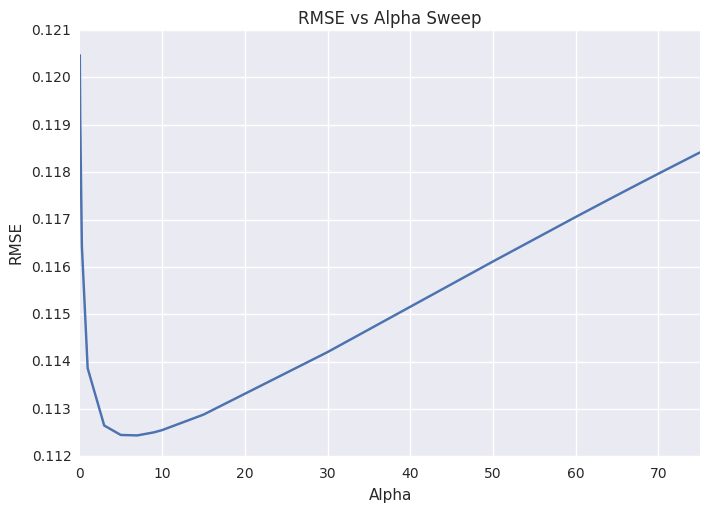

In [10]:
# Make a plot for RMSE vs Alphas to see where is the minimum
rmse = []
for i in score:
    rmse.append(np.sqrt(-i))
print(rmse)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 7, 9, 10, 15, 30, 50, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 75]
cv_ridge = pd.Series(rmse, index = alphas)
_ = cv_ridge.plot(title = "RMSE vs Alpha Sweep")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

print("Minimum RMSE for Ridge: ", cv_ridge.min())

In [11]:
# Do a quick CV to see what RMSE score we can expect from Ridge.
ridge = Ridge(alpha=66)
ridge_rmse = np.sqrt(-cross_val_score(ridge, x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(ridge_rmse.mean())

0.118263542962


In [12]:
# Do CV for Lasso to find the best alpha.
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.00099, 0.0005], cv=10).fit(x_train, y_train)
lasso_score = np.sqrt(-cross_val_score(model_lasso, x_train, y_train, cv=10, scoring="neg_mean_squared_error"))
lasso_pred = model_lasso.predict(x_test)
print(lasso_score.mean(), "Chosen alpha: ", model_lasso.alpha_)

(0.11114049996133354, 'Chosen alpha: ', 0.00050000000000000001)


Lasso picked 119 variables and eliminated the other 350 variables


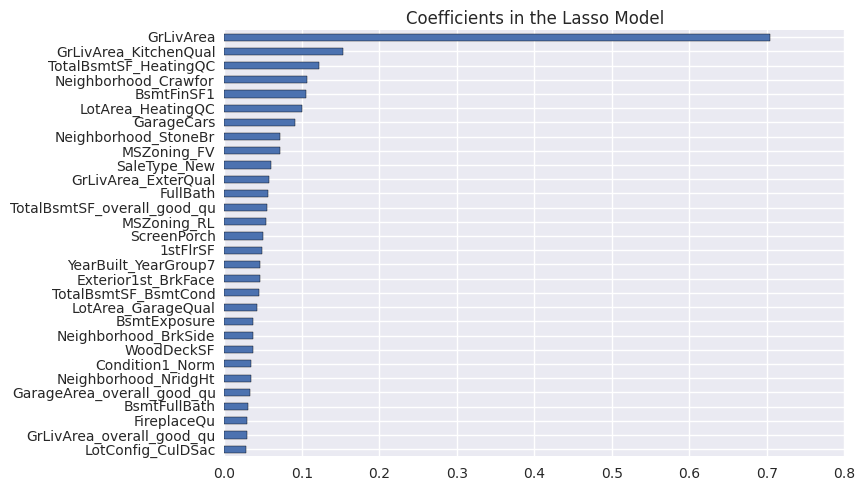

In [13]:
# Visualize the features selected by Lasso. Top 30.
coef = pd.Series(model_lasso.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " \
      +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values(ascending=False).head(30)])
_ = imp_coef.plot(kind = "barh").invert_yaxis()
_ = plt.title("Coefficients in the Lasso Model")

Add XGBoost to the model to prepare for stacking.

In [14]:
import xgboost as xgb
from xgboost import XGBRegressor

338
     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         10.379809       0.018994        10.379825        0.004113
1          9.344438       0.019747         9.344455        0.003339
2          8.412638       0.019979         8.412657        0.003112
3          7.574534       0.020125         7.574015        0.002937
4          6.819751       0.019608         6.819150        0.002686
5          6.140031       0.019738         6.139945        0.002496
6          5.528175       0.019041         5.528431        0.002334
7          4.978031       0.018521         4.978291        0.002217
8          4.482974       0.018475         4.483027        0.001887
9          4.037067       0.017330         4.037452        0.002035
10         3.636092       0.016982         3.636315        0.001576
11         3.274846       0.016443         3.275281        0.001357
12         2.949580       0.016351         2.949910        0.001162
13         2.656715       0.015917         2

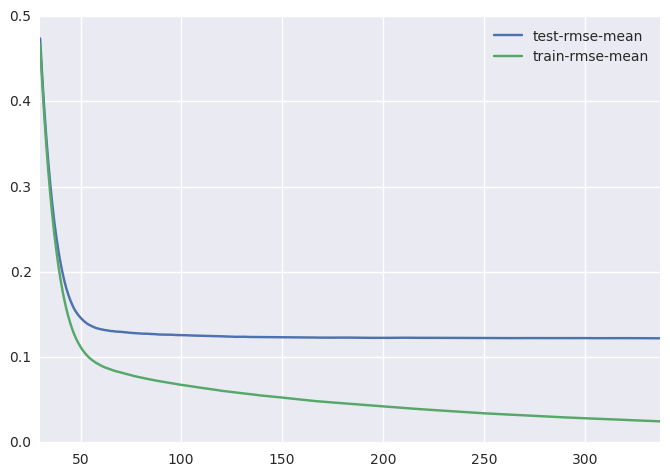

In [15]:
# Use CV to tune n_estimators needed.
xgb_cv_params = {'max_depth': 4, \
                 'subsample': 0.8, \
                 'n_estimators': 1000, \
                 'learning_rate': 0.1, \
                 'colsample_bytree': 0.5, \
                 'min_child_weight': 2, \
                 'gamma': 0, \
                 'scale_pos_weight': 1, \
                 'seed': 42, \
                }
model = xgb.cv(params=xgb_cv_params, \
               dtrain=xgb.DMatrix(x_train, y_train), \
               num_boost_round=1000, \
               nfold=5, \
               metrics='rmse', \
               early_stopping_rounds=100)

print(model.shape[0]) # This tells us n_estimators is 395
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
print(model)

In [16]:
# Grid Search with XGBoost. Tuning max_depth & min_child_weight
xgb_model = XGBRegressor()
xgb_params = {'max_depth': [3], \
              'subsample': [0.7], \
              'n_estimators': [5000], \
              'learning_rate': [0.01], \
              'colsample_bytree': [0.6], \
              'min_child_weight': [1.25], \
              'gamma': [0], \
              'scale_pos_weight': [1], \
              'reg_lambda':[0.9], \
              'seed': [42]
             }
# colsample_bytree = sqrt(288) = 17, because 288 features
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=10, verbose=1, scoring='neg_mean_squared_error')
xgb_grid.fit(x_train, y_train)
score = xgb_grid.cv_results_
print("Score: ", score)
print("mean_test_score: ", score['mean_test_score'])

mean_test_score = score['mean_test_score'].mean()
print("Average mean_test_score: ", mean_test_score)

xgb_pred = xgb_grid.predict(x_test) # This is the input training set for our stacked model.
print xgb_pred

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.2min finished


('Score: ', {'param_scale_pos_weight': masked_array(data = [1],
             mask = [False],
       fill_value = ?)
, 'rank_test_score': array([1], dtype=int32), 'param_gamma': masked_array(data = [0],
             mask = [False],
       fill_value = ?)
, 'split6_test_score': array([-0.01512385]), 'split7_train_score': array([-0.00107613]), 'split0_train_score': array([-0.00109364]), 'split2_test_score': array([-0.01042764]), 'mean_fit_time': array([ 43.12326479]), 'split3_train_score': array([-0.00101563]), 'split6_train_score': array([-0.00110473]), 'split9_test_score': array([-0.01660788]), 'std_test_score': array([ 0.00350359]), 'param_n_estimators': masked_array(data = [5000],
             mask = [False],
       fill_value = ?)
, 'params': ({'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1.25, 'n_estimators': 5000, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 3, 'gamma': 0},), 'split8_test_score': array([-0.01016642]), '

In [17]:
# Pretty printing the results.
print(xgb_grid.best_params_)
print(xgb_grid.best_score_, np.sqrt(-xgb_grid.best_score_))
print'\n'
print(score['params'])
df = pd.DataFrame()
df['rmse_train_score'] = np.sqrt(-score['mean_train_score'])
df['rmse_test_score'] = np.sqrt(-score['mean_test_score'])
print'\n'
print(df)
# df.to_csv('xgb_cv_2.csv',header=True, index_label='id')

{'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1.25, 'n_estimators': 5000, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 3, 'gamma': 0}
(-0.013800716426764011, 0.11747645051994042)


({'colsample_bytree': 0.6, 'scale_pos_weight': 1, 'learning_rate': 0.01, 'min_child_weight': 1.25, 'n_estimators': 5000, 'subsample': 0.7, 'reg_lambda': 0.9, 'seed': 42, 'max_depth': 3, 'gamma': 0},)


   rmse_train_score  rmse_test_score
0          0.032835         0.117476


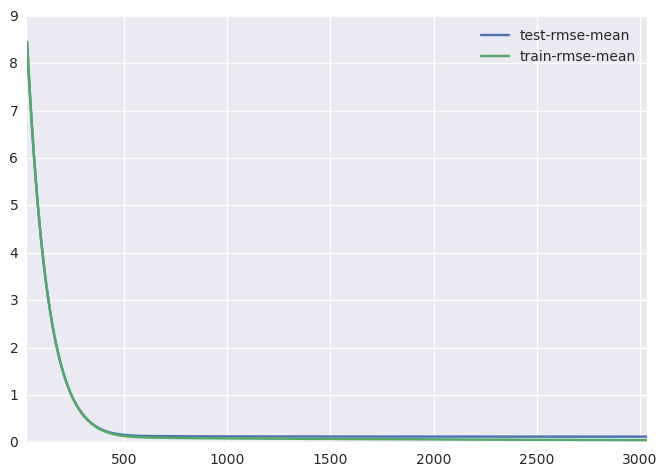

In [18]:
# After CV Check & Grid Search, we found the following parameters are the best.
# We use CV to check for overfitting.
xgb_cv_params = {'max_depth': 3, \
                 'subsample': 0.7, \
                 'n_estimators': 5000, \
                 'learning_rate': 0.01, \
                 'colsample_bytree': 0.6, \
                 'min_child_weight': 1.25, \
                 'gamma': 0, \
                 'scale_pos_weight': 1, \
                 'seed': 42, \
                }
model = xgb.cv(params=xgb_cv_params, \
               dtrain=xgb.DMatrix(x_train, y_train), \
               num_boost_round=5000, \
               nfold=5, \
               metrics='rmse', \
               early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
# print(model)

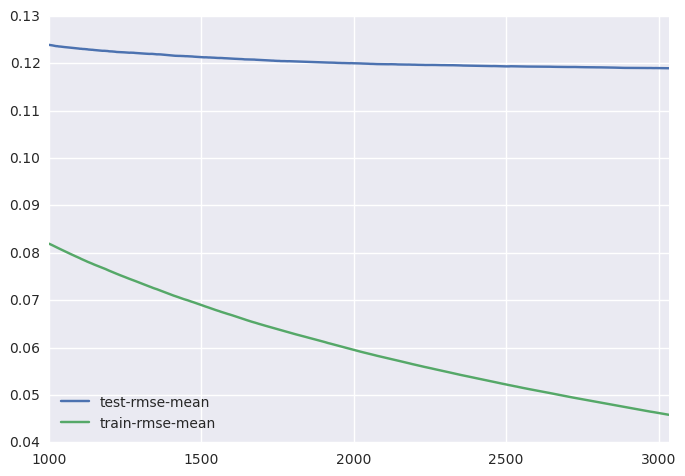

In [19]:
# Seems OK.
model.loc[1000:,["test-rmse-mean", "train-rmse-mean"]].plot()

Prepare stacking model below:
1. lasso
2. ridge
3. xgb

Wrapper:
Linear Regression

In [20]:
# We will use this function repeatedly for all 4 models to generate
# predicted weights to be trained for the stacked model.

def cv_model_output(model_func, model_name, x, y, n_folds=10):
    ''' Pass in a model with defined parameters,
    its name in string, x (features) to be trained,
    y (labels), and number of CV. '''

    folds = KFold(n_splits=n_folds)
    x_cv = np.array(x)
    y_cv = np.array(y)

    for k, (train_index, validation_index) in enumerate(folds.split(x_train)):
        x_cv_train, x_cv_val = x_cv[train_index], x_cv[validation_index]
        y_cv_train, y_cv_val = y_cv[train_index], y_cv[validation_index]

        model_func.fit(x_cv_train, y_cv_train)
        np.savetxt('{}_pred_fold_{}.txt'.format(model_name, k), np.exp(model_func.predict(x_cv_val)))
        np.savetxt('{}_test_fold_{}.txt'.format(model_name, k), y_cv_val)

In [21]:
# 1. Lasso with KFold. To be used for stacking.
ls_stack = Lasso(alpha=0.0005)
cv_model_output(ls_stack, 'ls', x_train, y_train, 10)

In [22]:
# 2. Ridge with KFold. To be used for stacking.
ridge_stack = Ridge(alpha=66)
cv_model_output(ridge_stack, 'ridge', x_train, y_train, 10)

In [23]:
# 3. Prepare XGB Kfold for stacker model.
xgb_stack = XGBRegressor(max_depth=3, \
                         subsample=0.7, \
                         n_estimators=5000, \
                         learning_rate=0.01, \
                         colsample_bytree=0.6, \
                         min_child_weight=1.25, \
                         gamma=0, \
                         scale_pos_weight=1, \
                         seed=42)
cv_model_output(xgb_stack, 'xgb', x_train, y_train, 10)

In [25]:
# 4. Prepare KNN for stacker model.
from sklearn.neighbors import KNeighborsRegressor

# Grid search to find the best n_neighbors for KNN.
parameters = {'n_neighbors':[10, 14, 22]}
neigh = KNeighborsRegressor(weights='distance')
neigh_grid = GridSearchCV(neigh, parameters, cv=10, verbose=0, n_jobs=2, scoring='neg_mean_squared_error')
neigh_grid.fit(x_train, y_train)

score = neigh_grid.cv_results_
print "\nmean_test_score: ", np.sqrt(-score['mean_test_score'])
print "\nParams: ", score['params']

best_param = neigh_grid.best_params_
print "\nBest Parameter is: ", best_param
print "\nBest Score is: ", neigh_grid.best_score_, np.sqrt(-neigh_grid.best_score_)

# Make prediction on the whole test set.
# Use this as input for wrapper (LinearRegression) prediction
knn_pred = neigh_grid.predict(x_test)


mean_test_score:  [ 0.16693694  0.16795244  0.17078662]

Params:  ({'n_neighbors': 10}, {'n_neighbors': 14}, {'n_neighbors': 22})

Best Parameter is:  {'n_neighbors': 10}

Best Score is:  -0.027867941864 0.166936939783


In [26]:
# 4...continued, KNN with KFold. To be used for stacking.
knn_stack = KNeighborsRegressor(weights='distance', n_neighbors=14)
cv_model_output(knn_stack, 'knn', x_train, y_train, 10)

In [27]:
# 5 Random Forest Regressor Grid Search.
from sklearn.ensemble import RandomForestRegressor

# Grid search to find the best hyperparameters for RF.
parameters = {'n_estimators': [150], \
              'max_features': [0.2], \
              'max_depth': [30], \
              'min_samples_leaf': [1]}
rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, parameters, cv=10, verbose=1, n_jobs=2, scoring='neg_mean_squared_error')
rf_grid.fit(x_train, y_train)

score = rf_grid.cv_results_
print "\nmean_test_score: ", np.sqrt(-score['mean_test_score'])
print "\nParams: ", score['params']

best_param = rf_grid.best_params_
print "\nBest Parameter is: ", best_param
print "\nBest Score is: ", neigh_grid.best_score_, np.sqrt(-rf_grid.best_score_)

# Make prediction on the whole test set.
# Use this as input for wrapper (LinearRegression) prediction
rf_pred = rf_grid.predict(x_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   18.1s finished



mean_test_score:  [ 0.13288685]

Params:  ({'max_features': 0.2, 'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 1},)

Best Parameter is:  {'max_features': 0.2, 'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 1}

Best Score is:  -0.027867941864 0.132886848949


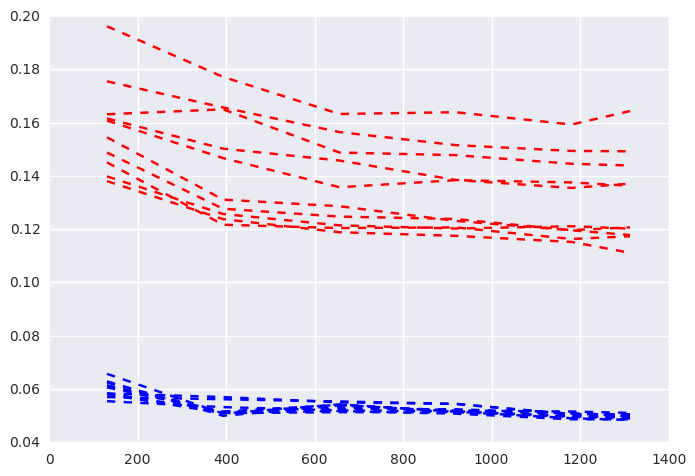

In [28]:
# Make plots for learning curve for RF to see if we are overfitting.
from sklearn.model_selection import learning_curve

rf_learning_curve = RandomForestRegressor(max_features=0.2, n_estimators=150, max_depth=30, min_samples_leaf=1)
train_sizes, train_scores, valid_scores = learning_curve(rf_learning_curve, x_train, y_train, 
                                                         train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1], cv=10,
                                                         scoring='neg_mean_squared_error', n_jobs=2)
_ = plt.plot(train_sizes, np.sqrt(-train_scores), 'b--', train_sizes, np.sqrt(-valid_scores), 'r--')

In [29]:
# 5...continued, RF with KFold. To be used for stacking.
rf_stack = rf_learning_curve
cv_model_output(rf_stack, 'rf', x_train, y_train, 10)

In [30]:
# Function to load in all models.
def load_model(model_name, n_folds=10):
    ''' Input the model name to be loaded, and n_folds used.
    Returns the model that is aggregated from weights predicted from CV sets. '''

    train = []
    for i in range(n_folds):
        train.append(np.loadtxt('model_4/{}_pred_fold_{}.txt'.format(model_name, i)))

    return train

In [33]:
# Stacker model (Lasso + Ridge + XGB + KNN) using Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Aggregate weights to be passed into layer 2 model
# 1. This is Lasso predicted weights from Kfold training set
train_lasso = load_model('ls', 10)
train_lasso_folds = np.hstack((train_lasso[0], train_lasso[1], train_lasso[2], train_lasso[3], \
                               train_lasso[4], train_lasso[5], train_lasso[6], \
                               train_lasso[7], train_lasso[8], train_lasso[9]))
print "\nChecking Lasso trainin set size: ", train_lasso_folds.shape

rmse_check_1 = np.sqrt(mean_squared_error(np.log(train_lasso_folds), y_train))
print "Lasso RMSE: ", rmse_check_1


# 2. This is Ridge predicted weights from Kfold training set
train_ridge = load_model('ridge', 10)
train_ridge_folds = np.hstack((train_ridge[0], train_ridge[1], train_ridge[2], train_ridge[3], \
                               train_ridge[4], train_ridge[5], train_ridge[6], \
                               train_ridge[7], train_ridge[8], train_ridge[9]))
print "\nChecking Ridge trainin set size: ", train_ridge_folds.shape

rmse_check_2 = np.sqrt(mean_squared_error(np.log(train_ridge_folds), y_train))
print "Ridge RMSE: ", rmse_check_2


# 3. This is xgb predicted weights from Kfold training set
train_xgb = load_model('xgb', 10)
train_xgb_folds = np.hstack((train_xgb[0], train_xgb[1], train_xgb[2], train_xgb[3], \
                             train_xgb[4], train_xgb[5], train_xgb[6], \
                             train_xgb[7], train_xgb[8], train_xgb[9]))
print "\nChecking XGB training set size: ", train_xgb_folds.shape

rmse_check_3 = np.sqrt(mean_squared_error(np.log(train_xgb_folds), y_train))
print "XGB RMSE: ", rmse_check_3


# 4. This is knn predicted weights from Kfold training set
train_knn = load_model('knn', 10)
train_knn_folds = np.hstack((train_knn[0], train_knn[1], train_knn[2], train_knn[3], \
                             train_knn[4], train_knn[5], train_knn[6], \
                             train_knn[7], train_knn[8], train_knn[9]))
print "\nChecking knn training set size: ", train_knn_folds.shape

rmse_check_4 = np.sqrt(mean_squared_error(np.log(train_knn_folds), y_train))
print "knn RMSE: ", rmse_check_4


# 5. This is rf predicted weights from Kfold training set
train_rf = load_model('rf', 10)
train_rf_folds = np.hstack((train_rf[0], train_rf[1], train_rf[2], train_rf[3], \
                            train_rf[4], train_rf[5], train_rf[6], \
                            train_rf[7], train_rf[8], train_rf[9]))
print "\nChecking rf training set size: ", train_rf_folds.shape

rmse_check_5 = np.sqrt(mean_squared_error(np.log(train_rf_folds), y_train))
print "rf RMSE: ", rmse_check_5


# Resize the ridge and knn prediction so they can fit into the stacker.
ridge_resized = np.resize(ridge_pred, (1459,))
knn_resized = np.resize(knn_pred, (1459,))
print '\n', xgb_pred.shape, lasso_pred.shape, ridge_resized.shape, knn_resized.shape, rf_pred.shape
# Stacking starts here.
layer_1_train_x = np.vstack((train_xgb_folds, train_lasso_folds, train_ridge_folds, train_rf_folds)).T
layer_1_test_x = np.vstack((xgb_pred, lasso_pred, ridge_resized, rf_pred)).T
lr = LinearRegression()
lr_rmse = np.sqrt(-cross_val_score(lr, np.log(layer_1_train_x), y_train, cv=5, scoring='neg_mean_squared_error'))
print "\nStacker RMSE: ", (lr_rmse.mean())

lr.fit(np.log(layer_1_train_x), y_train)
final_pred = lr.predict(layer_1_test_x)
df_final_pred = pd.DataFrame(np.exp(final_pred), index=test["Id"], columns=["SalePrice"])
df_final_pred.to_csv('submission9.csv', header=True, index_label='Id')
print "\n", df_final_pred.head()


Checking Lasso trainin set size:  (1458,)
Lasso RMSE:  0.112229412799

Checking Ridge trainin set size:  (1458,)
Ridge RMSE:  0.117605942387

Checking XGB training set size:  (1458,)
XGB RMSE:  0.117635216797

Checking knn training set size:  (1458,)
knn RMSE:  0.167952442091

Checking rf training set size:  (1458,)
rf RMSE:  0.132003171424

(1459,) (1459,) (1459,) (1459,) (1459,)

Stacker RMSE:  0.110646233434

          SalePrice
Id                 
1461  120106.066247
1462  162507.006691
1463  178380.415832
1464  198737.904503
1465  198418.265919
